###### The University of Melbourne, School of Computing and Information Systems

# COMP30027 Machine Learning, 2024 Semester 1

## Assignment 1: Wine quality classification with K-NN


**Student ID(s):** `1269602`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **


## 1. K-NN classifier


In [88]:
import random
import numpy as np
import pandas as pd
from collections import Counter 

class KNNClassifier:
    def __init__(self, k, debug=False):
        self.k = k
        self.debug = debug

    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []
        for _, row in X_test.iterrows():
            # For each instance in test, compute euclidean distance to each instance in training 
            distances = [self.euclidean_distance(row.values, x_train) for _, x_train in self.X_train.iterrows()]
            # Find nearest neighbours and take their labels 
            nearest_neighbors = np.argsort(distances)[:self.k]
            nearest_labels = [self.y_train[neighbor] for neighbor in nearest_neighbors]

            if self.debug:
                print("Instance", _)
                print("Distance Array", distances)
                print(f'Indexes of {self.k} nearest neighbours', nearest_neighbors)
                print('With labels:', nearest_labels)

            # Majority Vote (when K > 1)
            label_counts = Counter(nearest_labels)
            most_common = label_counts.most_common()

            # Choose winning label
            if len(most_common) == 1 or most_common[0][1] > most_common[1][1]:
                predictions.append(most_common[0][0])
            else:
                # Tie-break by taking label of 1-NN 
                predictions.append(nearest_labels[0])
        
        return predictions

In [89]:
# Read training and testing dataset into dataframes
train_df = pd.read_csv("winequality-train.csv")
test_df = pd.read_csv("winequality-test.csv")

print(train_df.head())

   fixedAcidity  volatileAcidity  citricAcid  residualSugar  chlorides  \
0           7.9             0.18        0.37           1.20      0.040   
1           8.3             0.42        0.62          19.25      0.040   
2           6.6             0.17        0.38           1.50      0.032   
3           6.2             0.66        0.48           1.20      0.029   
4           6.5             0.31        0.14           7.50      0.044   

   freeSulfurDioxide  totalSulfurDioxide  density    pH  sulphates  alcohol  \
0               16.0                75.0   0.9920  3.18       0.63     10.8   
1               41.0               172.0   1.0002  2.98       0.67      9.7   
2               28.0               112.0   0.9914  3.25       0.55     11.4   
3               29.0                75.0   0.9892  3.33       0.39     12.8   
4               34.0               133.0   0.9955  3.22       0.50      9.5   

   quality  
0        0  
1        0  
2        1  
3        1  
4        0  


In [90]:
# Calculate the distribution of labels 
def calc_prior(data):
    prior_prob = {}

    labels = data['quality']
    unique_labels, counts = np.unique(labels, return_counts=True)
    n = counts.sum()

    for i in range(len(unique_labels)):
        prior_prob[unique_labels[i]] = (counts[i] / n).round(2)

    return prior_prob

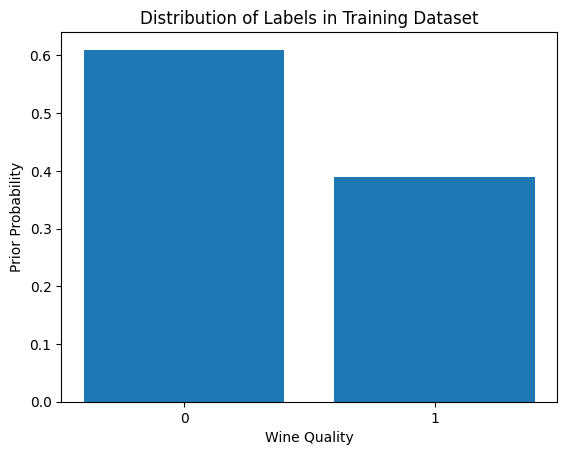

In [91]:
# Visualise training dataset split 
import matplotlib.pyplot as plt

prior_probs = calc_prior(train_df)

# Convert numerical keys to strings
prior_probs_str = {str(key): value for key, value in prior_probs.items()}

# Plotting
plt.bar(prior_probs_str.keys(), prior_probs_str.values())
plt.xlabel('Wine Quality')
plt.ylabel('Prior Probability')
plt.title('Distribution of Labels in Training Dataset')
plt.show()

In [92]:
# Separate features and class for training df
X_train = train_df.drop(columns=['quality'])
y_train = train_df['quality']

# Separate features and class for testing df
X_test = test_df.drop(columns=['quality'])
y_test = test_df['quality']

print(X_train.head())
print(y_train.head())
print(X_test.head())
print(y_test.head())

   fixedAcidity  volatileAcidity  citricAcid  residualSugar  chlorides  \
0           7.9             0.18        0.37           1.20      0.040   
1           8.3             0.42        0.62          19.25      0.040   
2           6.6             0.17        0.38           1.50      0.032   
3           6.2             0.66        0.48           1.20      0.029   
4           6.5             0.31        0.14           7.50      0.044   

   freeSulfurDioxide  totalSulfurDioxide  density    pH  sulphates  alcohol  
0               16.0                75.0   0.9920  3.18       0.63     10.8  
1               41.0               172.0   1.0002  2.98       0.67      9.7  
2               28.0               112.0   0.9914  3.25       0.55     11.4  
3               29.0                75.0   0.9892  3.33       0.39     12.8  
4               34.0               133.0   0.9955  3.22       0.50      9.5  
0    0
1    0
2    1
3    1
4    0
Name: quality, dtype: int64
   fixedAcidity  volatil

In [93]:
# Initiate the KNN classifier and fit it to the training data 
knn = KNNClassifier(k=3, debug=False)
knn.fit(X_train, y_train)

In [94]:
# Make predictions on the test data
predictions = knn.predict(X_test.head(100))

# Evaluate the performance of the classifier
accuracy = np.mean(predictions == y_test.head(100))
print("Accuracy:", accuracy)

Accuracy: 0.68


In [100]:
# Visualise the predictions made by KNN Classifier
num_instances = 1350

# Make predictions on the test data
predictions = knn.predict(X_test.head(num_instances))
true_labels = y_test.head(num_instances)

results_df = pd.DataFrame({'Predicted': predictions, 'True Label': true_labels})

# Calculate accuracy
accuracy = round(np.mean(predictions == true_labels) * 100, 2)

print("Results for the first", num_instances, "instances:")
print(results_df)
print(f"\nOverall Accuracy: {accuracy}%")

## 2. 1-NN classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.


## 3. Normalization

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.


## 4. Model extensions

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.


### 4.1

Compare the performance of your best 1-NN model from Question 3 to a Gaussian naive Bayes model on this dataset (you may use library functions to implement the Gaussian naive Bayes model). In your write-up, state the accuracy of the naive Bayes model and identify instances where the two models disagree. Why do the two models classify these instances differently?


### 4.2

Implement two additional distance measures for your K-NN model: cosine similarity and Mahalanobis distance (you may use library functions for these distance measures). Do 1-NN classification using each of these new distance measures and the three normalization options from Question 3. Discuss how the new distance metrics compare to Euclidean distance and how each metric is affected by normalization.


### 4.3

Implement either of the two K-NN weighting strategies discussed in lecture (inverse linear distance or inverse distance). Compare the performance of the weighted and majority vote models for a few different values of K. In your write-up, discuss how weighting strategy and the value of K affect the model's decisions.


### 4.4

Measure the empirical distribution of class labels in the training dataset (what percentage of the training data comes from each class). Then evaluate the distribution of labels predicted by your K-NN model for the test data, for a range of values for K. Does the class distribution of the predicted labels match the class distribution of the training data? Explain why or why not.
